In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import xarray as xr
from scipy.interpolate import interp2d
import scipy.optimize as sp

# define constants
m_u = 1.6605402*(10**(-27))
c = 2.99792458*(10**10)
E_h = 4.35974*(10**(-18))
Angstrom = 10**(-10)

In [3]:
def extract(dir):
    '''
    Input a directory of gaussian output files

    Returns an xarray DataArray object of energies with bond length and angle
    as coordinates

    The length and angle data are taken from the file name as this is easier +
    runs slightly quicker, but for files where the indices don't line up this
    would need to be changed
    '''

    # Parameters extracted from file names
    bLen = list()
    bAngle = list()
    for FileName in os.listdir(dir):
        n = FileName.split("theta")
        bLen.append(float(n[0][5:]))
        bAngle.append(float(n[1][:-4]))

    # unique function collapses arrays to only unique values and orders them
    bLen = np.unique(bLen)
    bAngle = np.unique(bAngle)
    
    # create xarray object to contain energies
    fill_array = np.zeros((len(bLen),len(bAngle)))
    E = xr.DataArray(
        data = fill_array,
        name=dir[:3],
        dims = ['Bond_length','Bond_angle'],
        coords=(
            ('Bond_length',bLen),
            ('Bond_angle',bAngle),
    ),
        attrs=dict(
            description=f'{dir} energy data with bond length and angle',
            length_unit='Angstrom',
            angle_unit='Degrees'
            )
    )

    # Parse each file and fill output array with energies
    for FileName in os.listdir(dir):
        n = FileName.split("theta")    
        length = float(n[0][5:])
        angle = float(n[1][:-4])

        RawText = open(f"{dir}/{FileName}","r")
        for line in RawText:
            if "SCF Done:" in line:
                l = line.split()
                E.loc[length,angle] = l[4]
    print(dir + ' energies extracted')
    return E

In [4]:
# Extract data and show resulting array
h2o = extract('H2Ooutfiles')
h2o

H2Ooutfiles energies extracted


<xarray.DataArray 'H2O' (Bond_length: 25, Bond_angle: 91)>
array([[-75.70705381, -75.71098123, -75.71476669, ..., -75.75718054,
        -75.75649832, -75.75583763],
       [-75.82565047, -75.82920916, -75.83264039, ..., -75.86307975,
        -75.86234643, -75.86163664],
       [-75.90266778, -75.90588792, -75.90899346, ..., -75.9281185 ,
        -75.92733343, -75.92657377],
       ...,
       [-75.65176775, -75.65070124, -75.64972418, ..., -75.59265557,
        -75.59146892, -75.59029019],
       [-75.63479769, -75.6334978 , -75.6322907 , ..., -75.57549356,
        -75.57440964, -75.573335  ],
       [-75.61899215, -75.6174709 , -75.61604301, ..., -75.55934498,
        -75.55837478, -75.55741546]])
Coordinates:
  * Bond_length  (Bond_length) float64 0.7 0.75 0.8 0.85 ... 1.75 1.8 1.85 1.9
  * Bond_angle   (Bond_angle) float64 70.0 71.0 72.0 73.0 ... 158.0 159.0 160.0
Attributes:
    description:  H2Ooutfiles energy data with bond length and angle
    length_unit:  Angstrom
    angle_unit:   Degrees

In [5]:
h2s = extract('H2Soutfiles')
h2s

H2Soutfiles energies extracted


<xarray.DataArray 'H2S' (Bond_length: 25, Bond_angle: 91)>
array([[-395.79755828, -395.80114662, -395.80462758, ..., -395.80258171,
        -395.80129332, -395.80004486],
       [-396.48448823, -396.48771108, -396.49083303, ..., -396.47518715,
        -396.47383047, -396.47251615],
       [-397.01498173, -397.01794606, -397.02081397, ..., -396.99501202,
        -396.99360182, -396.9922359 ],
       ...,
       [-398.58006174, -398.58100852, -398.58191827, ..., -398.50071964,
        -398.49826909, -398.49580489],
       [-398.56336141, -398.56424674, -398.565098  , ..., -398.48623385,
        -398.48383199, -398.48141211],
       [-398.54631713, -398.54714283, -398.54793742, ..., -398.47169166,
        -398.46935484, -398.46699712]])
Coordinates:
  * Bond_length  (Bond_length) float64 0.6 0.65 0.7 0.75 ... 1.65 1.7 1.75 1.8
  * Bond_angle   (Bond_angle) float64 70.0 71.0 72.0 73.0 ... 158.0 159.0 160.0
Attributes:
    description:  H2Soutfiles energy data with bond length and angle
    length_unit:  Angstrom
    angle_unit:   Degrees

In [38]:
def plot(energy,bound,az,el):
    '''
    Takes the xarray object from the extract function and a bound variable,
    
    The bound variable sets the proportion of the minimum energy that a datapoint 
    can be above the minimum and still be included in the reduced array
    
    Outputs a plot of the whole surface and a heatmap of the minimum
    '''
    E_min = energy.min()
    
    reduced = energy.where(energy<=E_min+(np.abs(E_min)*bound),drop=True)
    reduced = energy.loc[reduced.Bond_length,reduced.Bond_angle]
    # Plot the energies across the degrees of freedom
    fig = plt.figure(figsize=(5,10),dpi=400)

    ## Plotting
    # Plot subset nearer to minimum
    ax1 = fig.add_subplot(212)
    ax1.set_xlabel('Bond angle / \u00b0')
    ax1.set_ylabel('r / $\AA$')
    ax1.set_title('View of minimum as a heatmap')

    c1 = ax1.pcolormesh(reduced.Bond_angle,reduced.Bond_length,reduced,cmap=\
    'Greens_r',edgecolors='black',linewidth=0.25,vmin=reduced.min(),vmax=reduced.max())

    fig.colorbar(c1,ax=ax1,shrink=0.5,aspect=5,location='right',pad=0.025,label='Energy / Hartree')

    # Plot full data
    ax = fig.add_subplot(211,projection='3d')
    ax.set_xlabel('Bond angle / \u00b0')
    ax.set_ylabel('r / $\AA$')
    ax.set_zlabel('Energy / Hartree')
    ax.set_title('Energy surface of ' + energy.name)
    x,y = np.meshgrid(energy.Bond_angle,energy.Bond_length)

    surf = ax.plot_surface(x,y,energy,cmap='RdBu_r',edgecolors='black',linewidth=0.25)
    # fig.colorbar(surf,ax=ax,shrink=0.5,aspect=5,location='right',pad=0.025,label = 'Energy / Hartree')
    
    ax.azim = az
    ax.elev = el
    return reduced

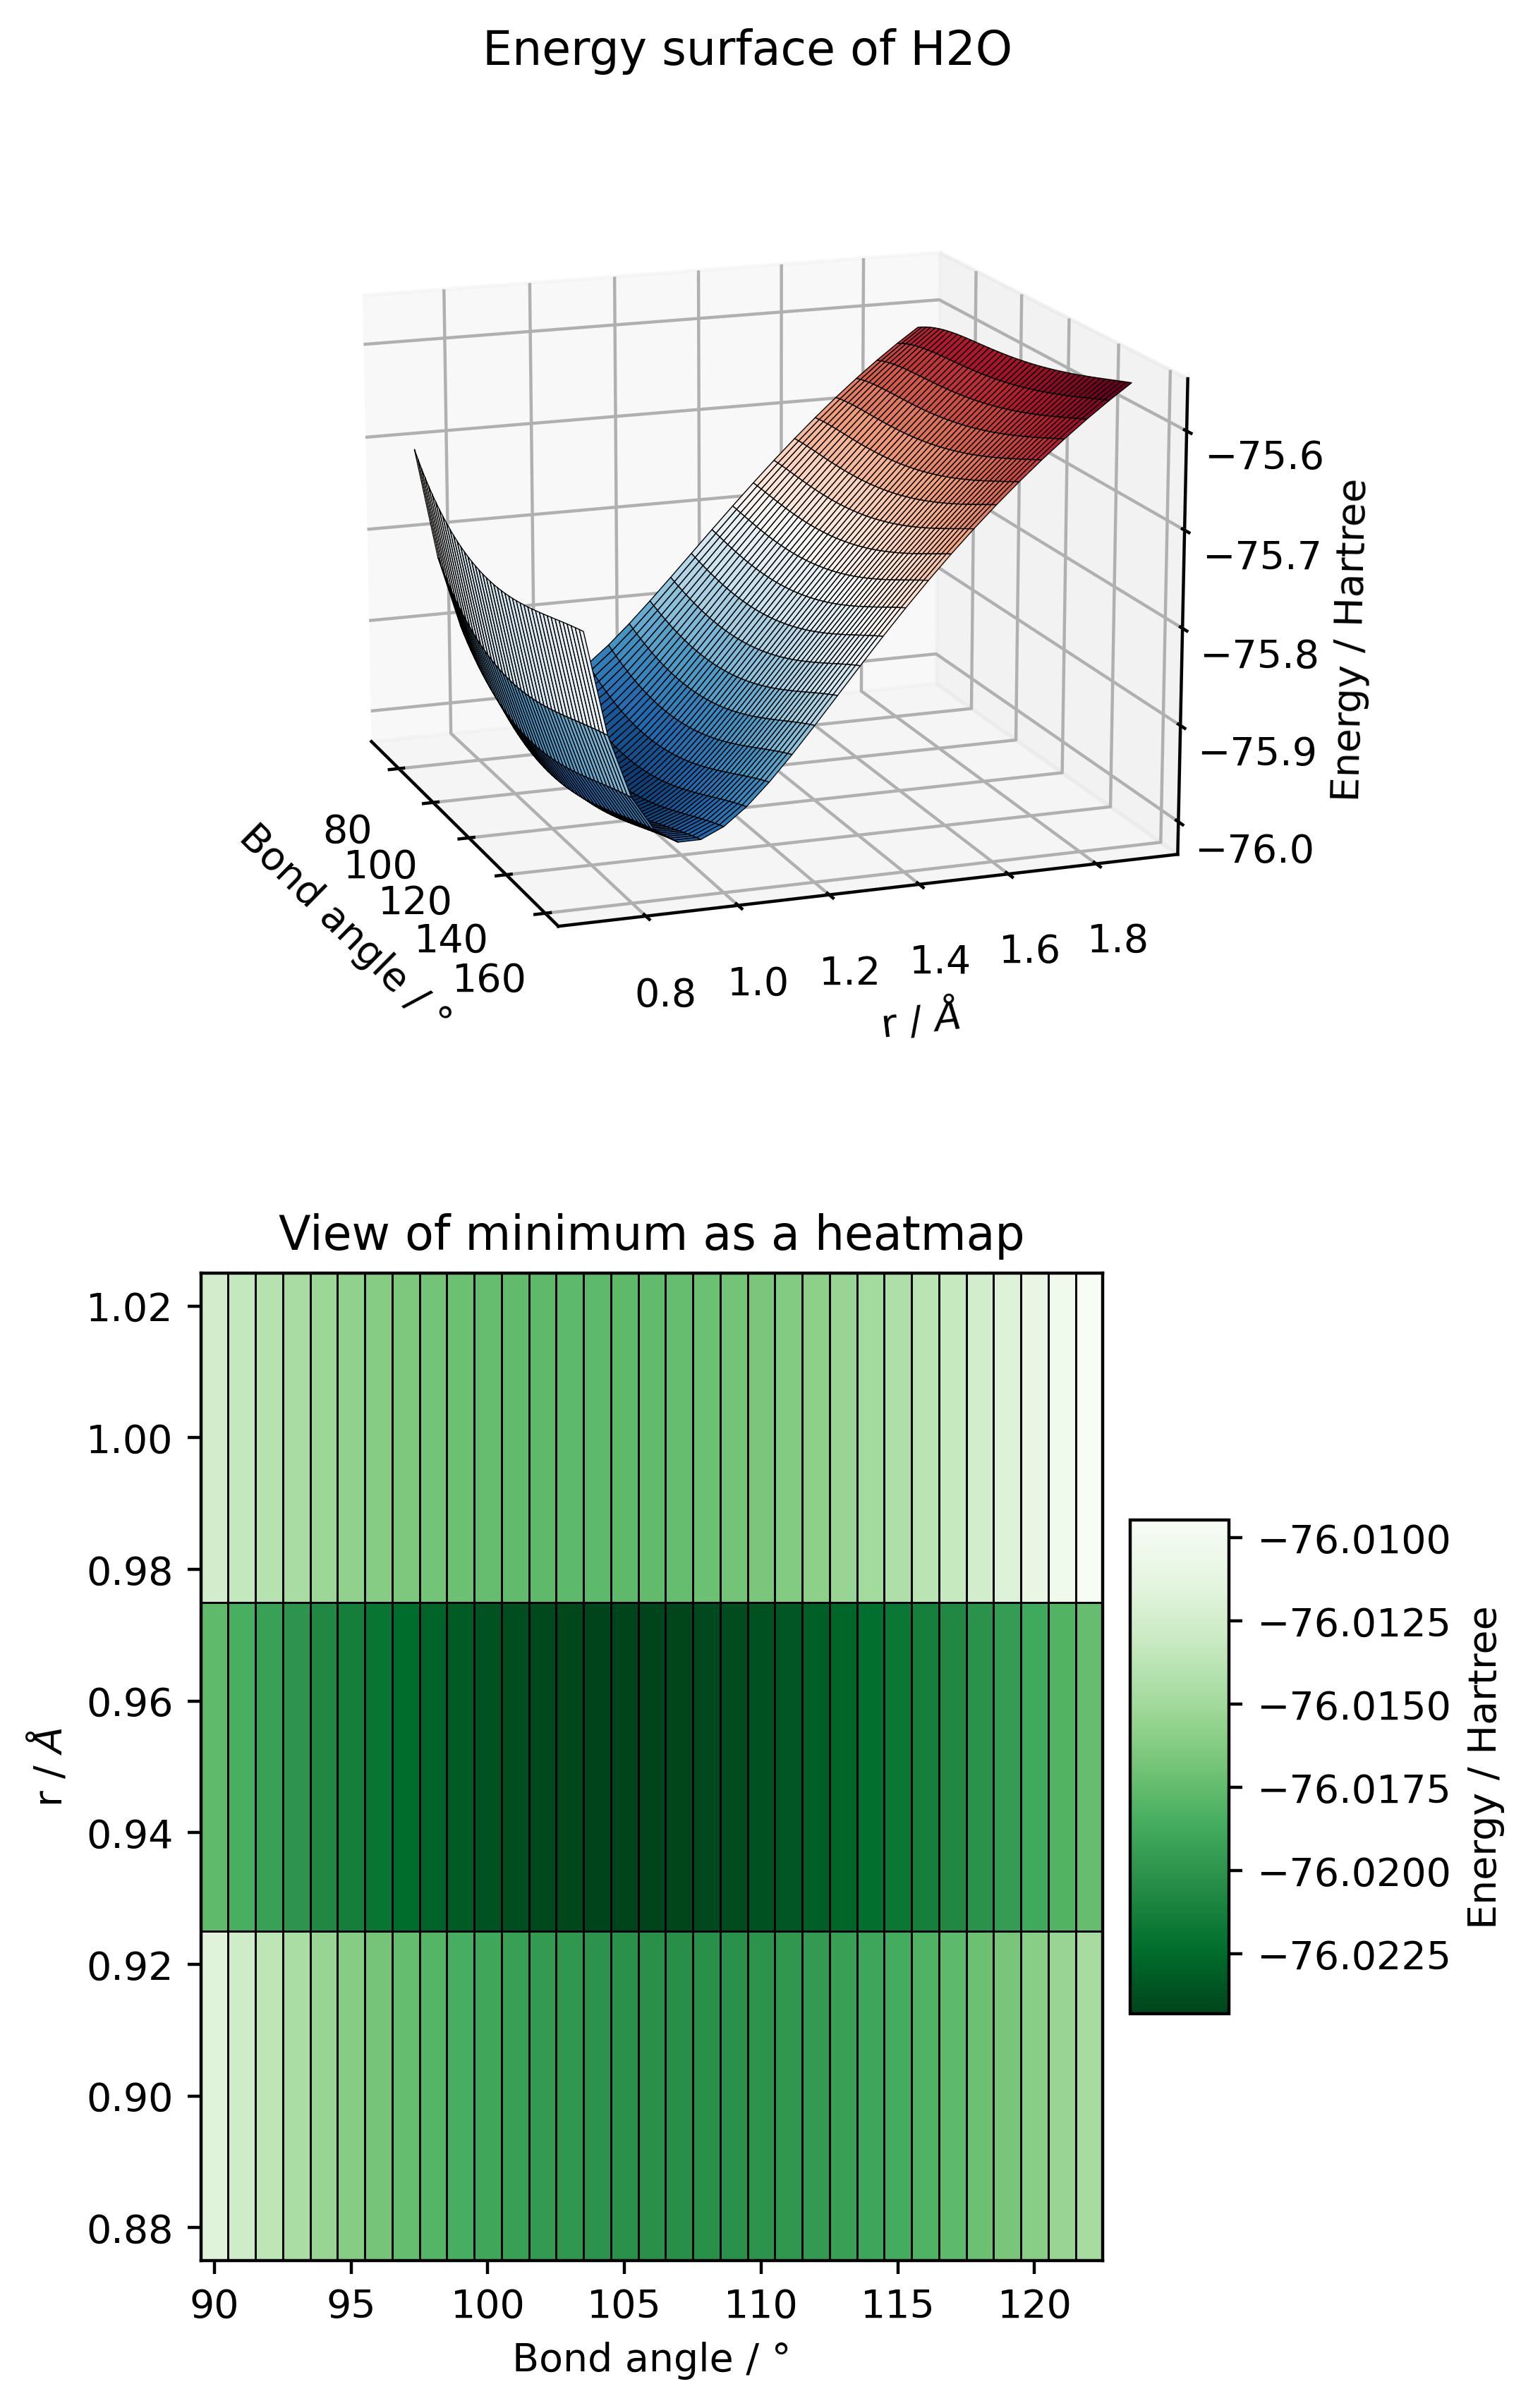

In [78]:
red = plot(h2o,0.0001,340,15)

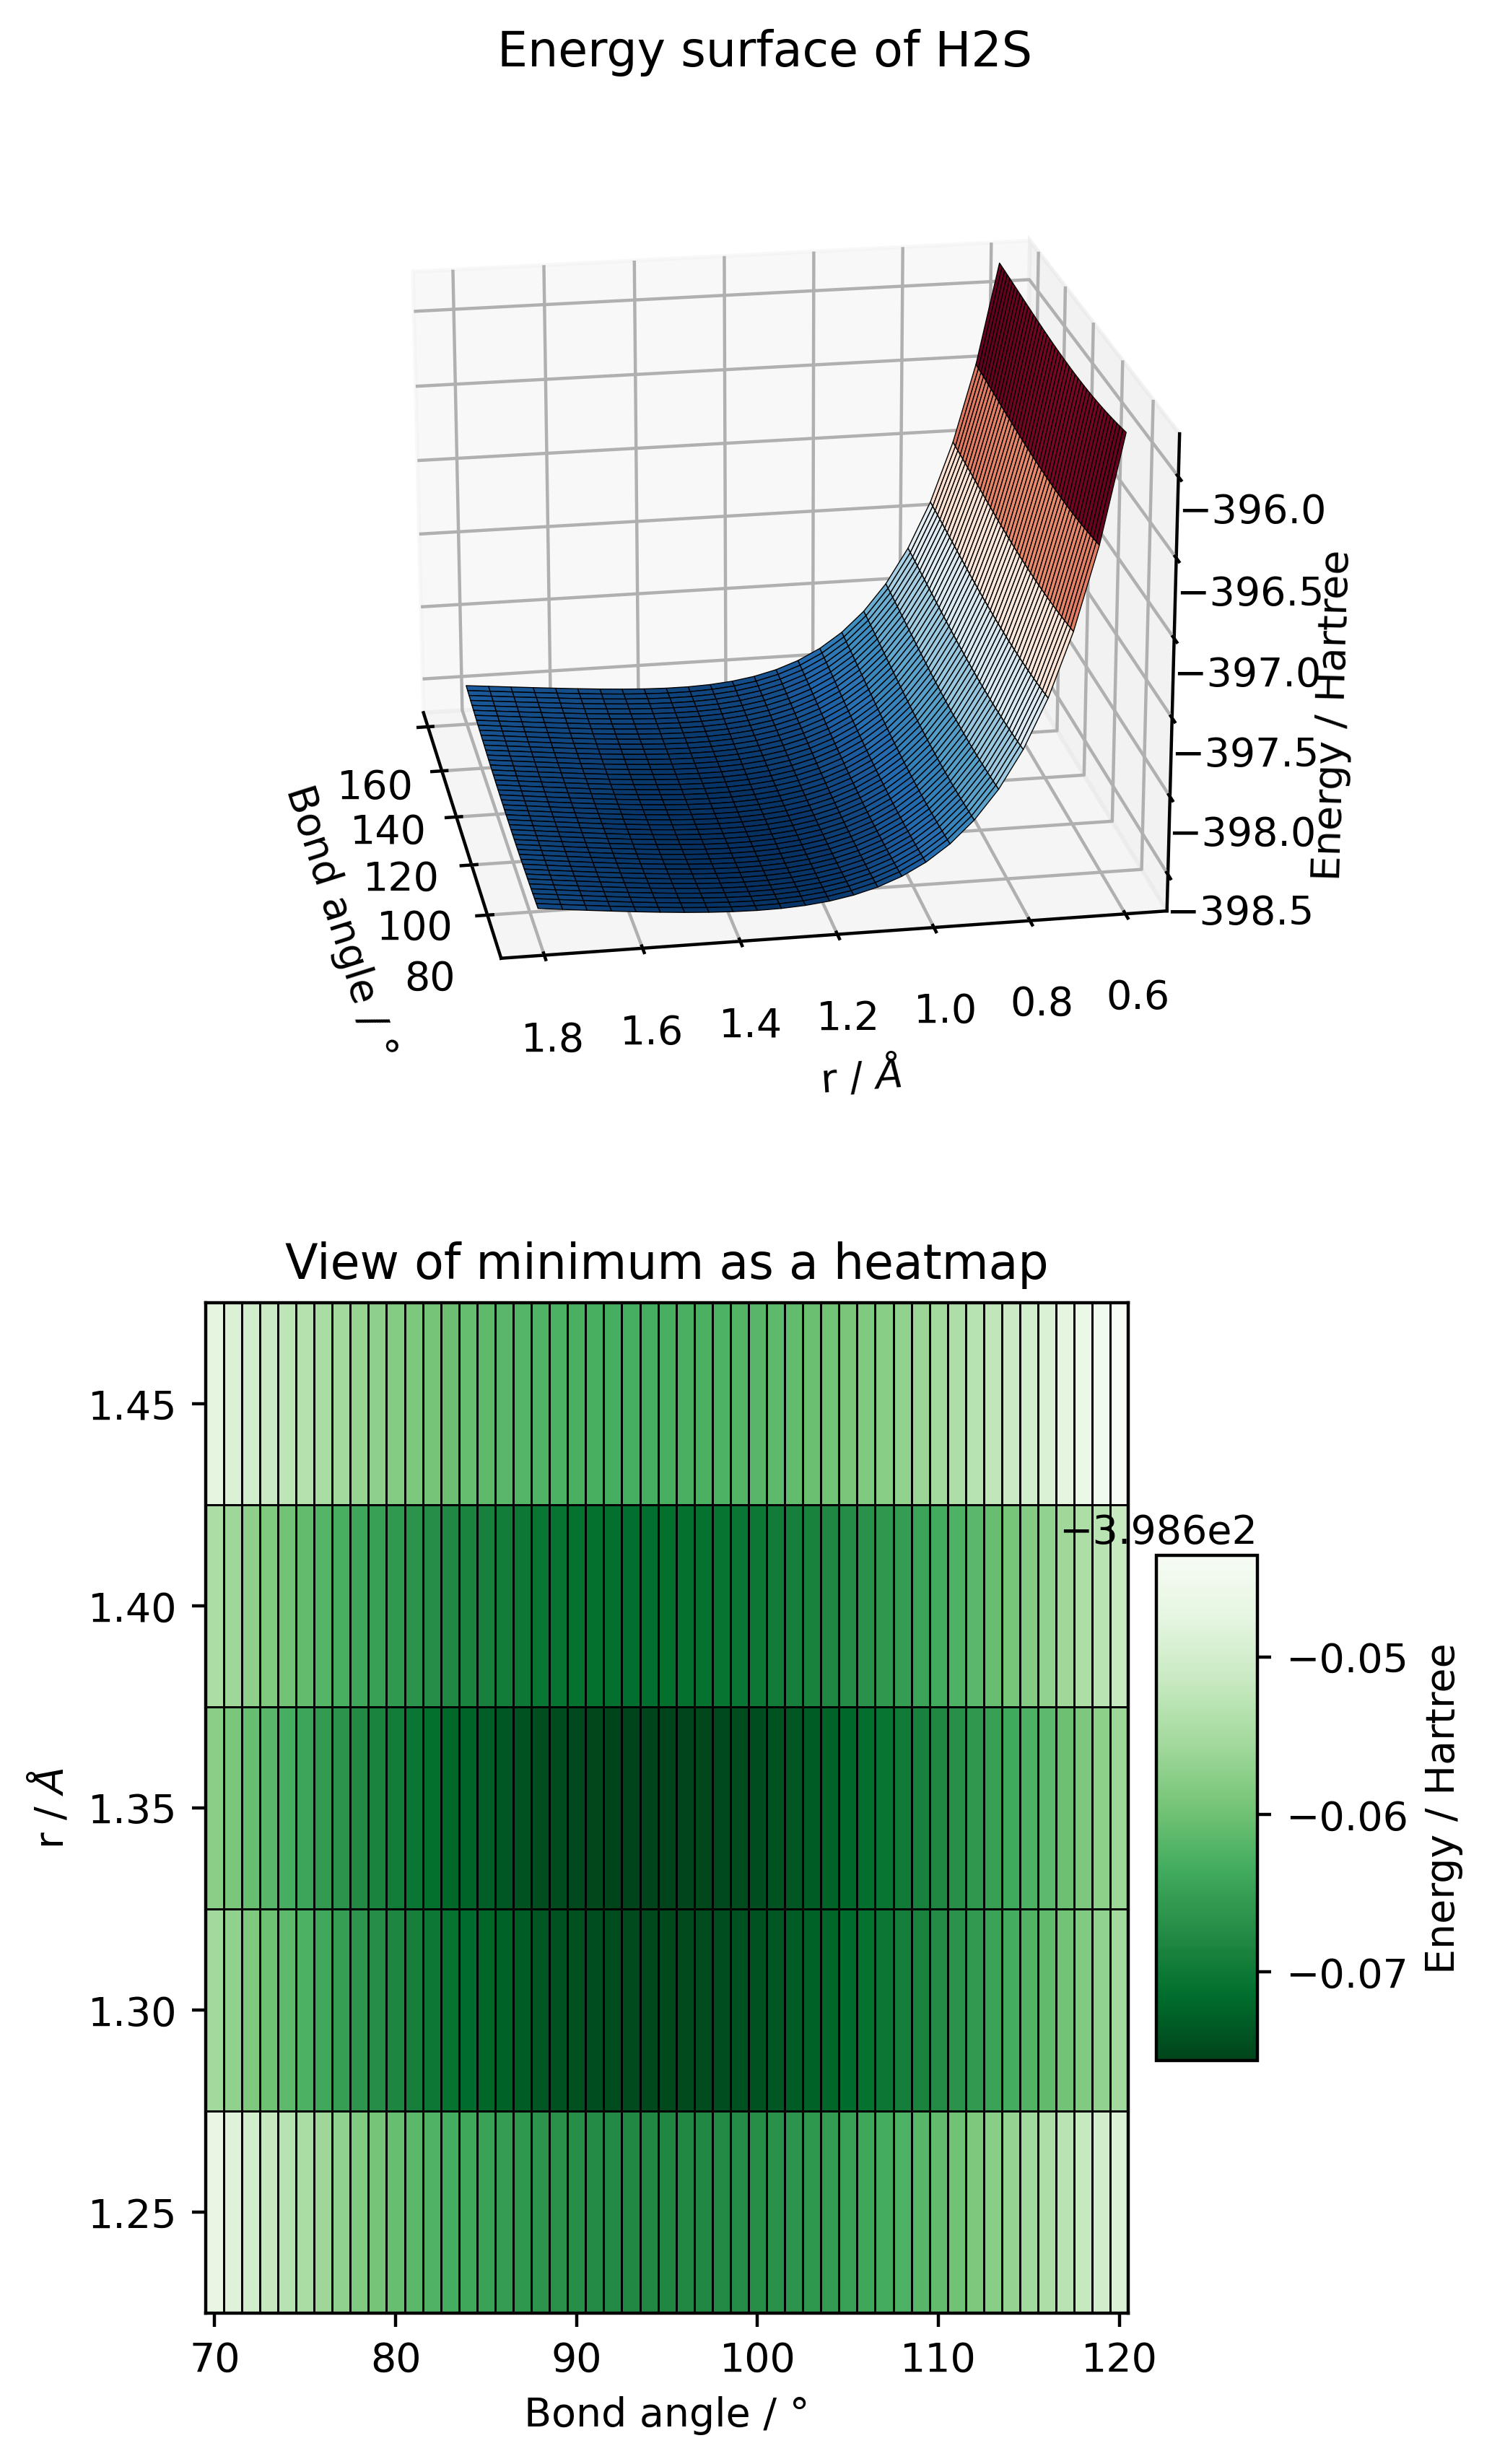

In [88]:
red1 = plot(h2s,0.00005,170,20)

In [82]:
def hz_to_cm(freq_hz):
    return freq_hz/c

def calc_freq(energy):
    ''' 
    Calculate minmum parameters using a fitted interpolation function from
    a matrix of the energies in bond length/angle space

    Returns and prints a scipy.optimize object 
    '''
    ### Determine equilibrium
    # fit function to surface
    surf_eq = interp2d(energy.Bond_angle,energy.Bond_length,energy,kind='linear')

    def fitfunc(babl):
        ba,bl = babl
        return surf_eq(ba,bl)

    # Create initial guess for minimization from minimum measured value
    idxmin = energy.argmin(('Bond_length','Bond_angle'))
    guess = [energy.Bond_length[idxmin['Bond_length']].data,energy.Bond_angle[idxmin['Bond_angle']].data]

    # Minimize surface to find equilibrium values
    equil = sp.fmin(fitfunc,guess)
    print('[Bond length / A, Bond Angle / ' + chr(176) + ']\n' + str(equil))
    

    ### Determine parameters
    # convert indices in energy matrix using equilibrium values (Also unit conv)
    r_values = (energy.Bond_length - equil[0])*10**(-10)
    theta_values = np.deg2rad(energy.Bond_angle - equil[1])

    # E_r = E_h*np.array(energy.loc[slice(energy.Bond_length.min(),energy.Bond_length.max()),equil[1]])
    E_r = E_h*np.array(energy.loc[:,equil[1]])

    E_theta = E_h*np.array(energy.loc[equil[0],:])

    # Fit function parameters to data
    r_param = np.polyfit(r_values,E_r,2)
    theta_param = np.polyfit(theta_values,E_theta,2)

    k_r = r_param[0]*2
    k_theta = theta_param[0]*2
    
    v_1 = np.multiply(1/(2*np.pi),np.sqrt(k_r/(2*m_u)))
    v_2 = np.multiply(1/(2*np.pi),np.sqrt(k_theta/(0.5*m_u*((equil[0]*Angstrom)**2))))

    v_1 = hz_to_cm(v_1)
    v_2 = hz_to_cm(v_2)
    return k_r,k_theta,v_1,v_2

In [84]:
out_h2o = calc_freq(red)

Optimization terminated successfully.
         Current function value: -76.012569
         Iterations: 17
         Function evaluations: 67
[Bond length / A, Bond Angle / °]
[  0.95 105.  ]


In [85]:
print(
    'k_r = ' + str(out_h2o[0]) + '\n'
    'k_theta = ' + str(out_h2o[1]) + '\n'
    'v_1 = ' + str(out_h2o[2]) + '\n'
    'v_2 = ' + str(out_h2o[3])
 )


k_r = 1868.1581291207406
k_theta = 7.605261141528039e-19
v_1 = 3981.6818087011925
v_2 = 1691.3098953722465


In [89]:
out_h2s = calc_freq(red1)
print(
    'k_r = ' + str(out_h2s[0]) + '\n'
    'k_theta = ' + str(out_h2s[1]) + '\n'
    'v_1 = ' + str(out_h2s[2]) + '\n'
    'v_2 = ' + str(out_h2s[3])
 )


Optimization terminated successfully.
         Current function value: -398.647611
         Iterations: 17
         Function evaluations: 67
[Bond length / A, Bond Angle / °]
[ 1.35 94.  ]
k_r = 881.0150633722167
k_theta = 8.622445946777574e-19
v_1 = 2734.3329812013
v_2 = 1267.275974289342


These aren't that close to the actual values, but are generally correct. 
It is probably as there are too many datapoints in the reduced datasets used,
also using the quadratic curve fit is simpler but does only find the curve along
one axis at a time.

# 2D curvefit method

In [274]:
# function to output frequencies
def v_calc(k_r,k_t,r_bar):
    v_1 = (1/(2*np.pi))*np.sqrt(k_r/(2*m_u))
    v_2 = (1/(2*np.pi))*np.sqrt(k_t/(0.5*m_u*((r_bar)**2)))

    v_1 = hz_to_cm(v_1)
    v_2 = hz_to_cm(v_2)

    print(
        'v_1 = ' + str(v_1) + '\n'
        'v_2 = ' + str(v_2)
    )
    return v_1,v_2

In [304]:
# Use known region of equilibrium to make this a bit quicker
# Also allow less points to be included in calculation
h2o_eq = h2o.loc[0.85:1.05,103:107]
# Unravel bond length and angle data for curve fit
l = np.empty(0)
a = np.empty(0)

for element in h2o_eq:
    for angle in element:
        l = np.append(l,angle.Bond_length.data)
        a = np.append(a,angle.Bond_angle.data)

# Convert to base units
l = l*Angstrom
a = np.deg2rad(a)

xydata = np.array([l,a])
# define funtion to fit to
def E(rt,e_0,k_r,r_eq,k_t,t_eq):
    r,t = rt
    energy = e_0 + 0.5*k_r*(r-r_eq)**2 + 0.5*k_t*(t-t_eq)**2
    return energy

# Reshape energy data
zdata = np.ravel(h2o_eq.data)
zdata = np.multiply(zdata,E_h)
# Create initial guess using result from the more simple fit
guess = np.array([-76.012569*E_h,1868.1581291207406,0.95*Angstrom,7.605261141528039*10**(-19),np.deg2rad(105)])


popt, pcov = sp.curve_fit(E,xydata,zdata,guess)

print(
    'E_0 = ' + str(popt[0]/E_h) + '\n'
    'k_r = ' + str(popt[1]) + '\n'
    'r_eq = ' + str(popt[2]/Angstrom) + '\n'
    'k_theta = ' + str(popt[3]) + '\n'
    'theta_eq = ' + str(np.rad2deg(popt[4])) + '\n'
 )


v = v_calc(popt[1],popt[3],popt[2])

E_0 = -76.02439590484593
k_r = 1926.9582622154487
r_eq = 0.9510965748215454
k_theta = 7.801811553928834e-19
theta_eq = 105.37378366672993

v_1 = 4043.8579159767237
v_2 = 1711.0505491641504


Changes values, but in the wrong direction acutally

Similar error in result, expecting ~3700cm-1 and 1595cm-1

### Try for H2S, expect not much different

In [307]:
# Use known region of equilibrium to make this a bit quicker
# Also allow less points to be included in calculation
h2s_eq = h2s.loc[1.25:1.45,92:96]
# Unravel bond length and angle data for curve fit
l = np.empty(0)
a = np.empty(0)

for element in h2o_eq:
    for angle in element:
        l = np.append(l,angle.Bond_length.data)
        a = np.append(a,angle.Bond_angle.data)

# Convert to base units
l = l*Angstrom
a = np.deg2rad(a)

xydata = np.array([l,a])
# define funtion to fit to
def E(rt,e_0,k_r,r_eq,k_t,t_eq):
    r,t = rt
    energy = e_0 + 0.5*k_r*(r-r_eq)**2 + 0.5*k_t*(t-t_eq)**2
    return energy

# Reshape energy data
zdata = np.ravel(h2s_eq.data)
zdata = np.multiply(zdata,E_h)
# Create initial guess using result from the more simple fit
guess = np.array([-398.647611,881.0150633722167,1.35*Angstrom,8.622445946777574*10**(-19),np.deg2rad(94)])


popt, pcov = sp.curve_fit(E,xydata,zdata,guess)
print(
    'E_0 = ' + str(popt[0]) + '\n'
    'k_r = ' + str(popt[1]) + '\n'
    'r_eq = ' + str(popt[2]/Angstrom) + '\n'
    'k_theta = ' + str(popt[3]) + '\n'
    'theta_eq = ' + str(np.rad2deg(popt[4])) + '\n'
 )


v = v_calc(popt[1],popt[3],popt[2])

E_0 = -1.7416574994412676e-15
k_r = 881.0150633722167
r_eq = 1.3500000000000003
k_theta = 8.622445946777574e-19
theta_eq = 94.0

v_1 = 2734.3329812013
v_2 = 1267.275974289342
